# Note:
- This notebook file may contain methods or algorithms that are NOT covered by the teaching content of BT4222 and hence will not be assessed in your midterm exam.
- It serves to increase your exposure in depth and breath to the practical methods in addressing the specific project topic. We believe it will be helpful for your current project and also your future internship endeavors.

## What is Content based filtering

Content based filtering uses item features to generate recommendations. Backbone of the method is that the algorithm will extract features from an item and compare it to a new item. If the two items are similar then the new item is recommended.

<img src="https://drive.google.com/uc?id=1WvHQ4x5ZLTjacyYZdyFcJLxlt1XegVnN"></img>


###1. Importing Libraries


In [ ]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.7 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125925 sha256=19b3a9ed1a8c50ed78e2cd73054f66e8741e9ebe0137c03d3055663b2cdffff4
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
# Loading and working with .csv files
import pandas as pd

# Dealing with arrays
import numpy as np

# Calculating the Tfidf vectors (more info in Section 3)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Visualization library
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer

###2. Exploring the Dataset


In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1FgXwJNw1Pg2WtkWCYZCnsZGrHxpTvCVP' -O IMDB_top_1000.csv

--2023-08-08 13:35:20--  https://docs.google.com/uc?export=download&id=1FgXwJNw1Pg2WtkWCYZCnsZGrHxpTvCVP
Resolving docs.google.com (docs.google.com)... 142.250.141.102, 142.250.141.138, 142.250.141.139, ...
Connecting to docs.google.com (docs.google.com)|142.250.141.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3kopt98213j2468g706u1om90f8k679i/1691501700000/09087602243759402880/*/1FgXwJNw1Pg2WtkWCYZCnsZGrHxpTvCVP?e=download&uuid=a983c208-233b-447e-9b83-cb93674e0de9 [following]
--2023-08-08 13:35:21--  https://doc-0g-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3kopt98213j2468g706u1om90f8k679i/1691501700000/09087602243759402880/*/1FgXwJNw1Pg2WtkWCYZCnsZGrHxpTvCVP?e=download&uuid=a983c208-233b-447e-9b83-cb93674e0de9
Resolving doc-0g-54-docs.googleusercontent.com (doc-0g-54-docs.googleusercontent.com)... 142.251.2.132, 2607:f8

In [ ]:
# Loading the csv file
df = pd.read_csv("/content/IMDB_top_1000.csv")

# Observing first 5 rows
df.head(5)

,Index,Title,Certificate,Duration,Genre,Rate,Metascore,Description,Cast,Info
0,0,The Shawshank Redemption,R,142 min,Drama,9.3,80.0,Two imprisoned men bond over a number of years...,"Director: Frank Darabont | Stars: Tim Robbins,...","Votes: 2,295,987 | Gross: $28.34M"
1,1,The Godfather,R,175 min,"Crime, Drama",9.2,100.0,The aging patriarch of an organized crime dyna...,Director: Francis Ford Coppola | Stars: Marlon...,"Votes: 1,584,782 | Gross: $134.97M"
2,2,The Dark Knight,PG-13,152 min,"Action, Crime, Drama",9.0,84.0,When the menace known as the Joker wreaks havo...,Director: Christopher Nolan | Stars: Christian...,"Votes: 2,260,649 | Gross: $534.86M"
3,3,The Godfather: Part II,R,202 min,"Crime, Drama",9.0,90.0,The early life and career of Vito Corleone in ...,Director: Francis Ford Coppola | Stars: Al Pac...,"Votes: 1,107,253 | Gross: $57.30M"
4,4,The Lord of the Rings: The Return of the King,PG-13,201 min,"Action, Adventure, Drama",8.9,94.0,Gandalf and Aragorn lead the World of Men agai...,"Director: Peter Jackson | Stars: Elijah Wood, ...","Votes: 1,614,369 | Gross: $377.85M"


###3. Item Representation

In content based filtering methods, items are described using a set of features. These features are compared with other items features using some relevant similarity metric.

Then we select items that have high similarity to the item selected by the user.

\\
**Why do we need to represent items?**

Items do not follow a particular structure. Therefore, comparing two items is not trivial. To address this issue, we first represent the items in the same dimensionality space.

For eg: Suppose we want to recommend movies based on their plots. Plot descriptions have varying length with different words. How do we compare the similarity between two texts of varying length? It is an extremely tedious approach. Instead we will map these varying length texts into a fixed sized vector.

\\
**How do we represent items?**

There are multiple methods to represent items.

Since we are recommending based on text data, we will be focusing on TFIDF and BERT based approach.

Please feel free to try any other forms of item representation.

<center>

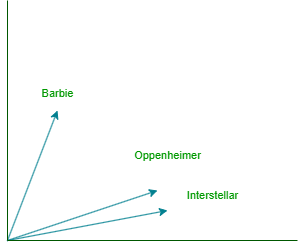


#### 3.1 TFIDF Approach

TFIDF stands for Term Frequency, Inverse Document Frequency

**Term Frequency:** It is the frequency of a particular "term" appearing in the document

<center>
$ TF(t_k, d_j) = \dfrac{f_{k, j}}{\max_z f_{z, j}} $
</center>

\\
<center>
$ IDF = \dfrac{\log N}{n_k} $
</center>


In [ ]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_scores =  tfidf.fit_transform(df['Description'])

In [ ]:
# Shape of tfidf vector is (number of documents, number of words)
# TFIDF has identified 2363 words in our case
tfidf_scores.shape

(285, 2363)

<BarContainer object of 10 artists>

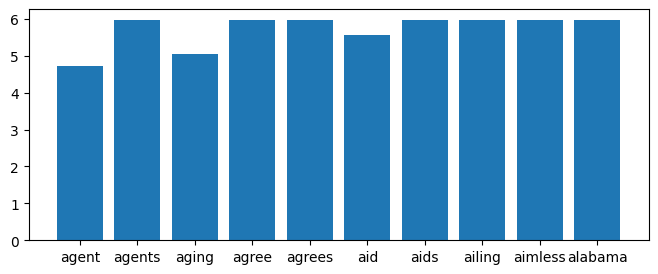

In [ ]:
#Looking at some of the IDF scores

idf_values = tfidf.idf_

# Get mapping from term to index
vocab_dict = tfidf.vocabulary_

# Get mapping from index to term
reverse_vocab = {}
for x in vocab_dict:
  reverse_vocab[vocab_dict[x]] = x

#Visualizing the words and their IDF scores
plt.figure(figsize=(8, 3))
plt.bar(x=[reverse_vocab[i] for i in range(80, 90)], height=idf_values[80:90])

#### 3.2 BERT based Approach

In this section, instead of using heuristics like TFIDF to encode the movie description, we can use a deep learning model.

BERT stands for Bidirectional Encoder Representations from Transformer. It is a language model trained on some task. It encodes text into a vector of size 768, we will use these encodings to compare items.

The inner workings of BERT are beyond the scope of this class, but you can read more about them here: <INSERT_LINK>

In [ ]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(df['Description'], show_progress_bar=True)

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
#Shape of BERT embeddings is (number of documents, 768)
embeddings.shape

(285, 768)

###4. Cosine similarity and Recommendations

Now that we have our representations with us, we need some similarity metric to compare them.

There are various similarity scores, but we will go ahead with Cosine Similarity.

Cosine similarity is:

$$ Score(A, B) = \cos θ = \dfrac{A \cdot B}{||A|| ||B||} $$

<center>

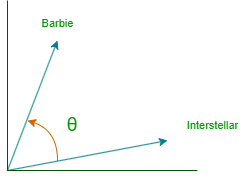

In [ ]:
"""
We precompute the similarity matrix, because during inference we simply need
index the matrix
"""

tfidf_cosine_sim = (tfidf_scores @ tfidf_scores.T).toarray()
bert_cosine_sim = cosine_similarity(embeddings)

In [ ]:
#Shape of the similarity matrix (number of documents, number of documents)
bert_cosine_sim.shape, tfidf_cosine_sim.shape

((285, 285), (285, 285))

In [ ]:
def recommend_movies(data, movie_name, similarity_matrix, top_k=10):
  #Get the index of the movie from our database
  index = data.index[data['Title'] == movie_name][0]

  # Get the similarity scores of our movie with every other movie in the database
  score_arr = similarity_matrix[index]

  # We sort the score and reverse it to get the highest correlated movie
  # We do argsort here because we are interested in the indices.
  reveresed_score_arr = np.argsort(score_arr)[::-1]

  # Retrieve top K movies. We ignore the 0th element, because that contains the similarity score of our movie with itself
  top_k_movies = reveresed_score_arr[1:top_k + 1]

  return data.iloc[top_k_movies]

In [ ]:
recommend_movies(df, "The Dark Knight Rises", tfidf_cosine_sim, 5)

,Index,Title,Certificate,Duration,Genre,Rate,Metascore,Description,Cast,Info
117,117,Batman Begins,PG-13,140 min,"Action, Adventure",8.2,70.0,"After training with his mentor, Batman begins ...",Director: Christopher Nolan | Stars: Christian...,"Votes: 1,287,216 | Gross: $206.85M"
2,2,The Dark Knight,PG-13,152 min,"Action, Crime, Drama",9.0,84.0,When the menace known as the Joker wreaks havo...,Director: Christopher Nolan | Stars: Christian...,"Votes: 2,260,649 | Gross: $534.86M"
267,267,The Incredibles,PG,115 min,"Animation, Action, Adventure",8.0,90.0,"A family of undercover superheroes, while tryi...","Director: Brad Bird | Stars: Craig T. Nelson, ...","Votes: 646,521 | Gross: $261.44M"
170,170,Tae Guk Gi: The Brotherhood of War,R,140 min,"Action, Drama, War",8.1,64.0,When two brothers are forced to fight in the K...,"Director: Je-kyu Kang | Stars: Dong-Gun Jang, ...","Votes: 37,485 | Gross: $1.11M"
55,55,Django Unchained,R,165 min,"Drama, Western",8.4,81.0,"With the help of a German bounty hunter, a fre...",Director: Quentin Tarantino | Stars: Jamie Fox...,"Votes: 1,328,656 | Gross: $162.81M"


In [ ]:
recommend_movies(df, "The Dark Knight Rises", bert_cosine_sim, 5)

,Index,Title,Certificate,Duration,Genre,Rate,Metascore,Description,Cast,Info
86,86,Aliens,R,137 min,"Action, Adventure, Sci-Fi",8.3,84.0,Ellen Ripley is rescued by a deep salvage team...,Director: James Cameron | Stars: Sigourney Wea...,"Votes: 643,457 | Gross: $85.16M"
117,117,Batman Begins,PG-13,140 min,"Action, Adventure",8.2,70.0,"After training with his mentor, Batman begins ...",Director: Christopher Nolan | Stars: Christian...,"Votes: 1,287,216 | Gross: $206.85M"
27,27,Star Wars: Episode IV - A New Hope,PG,121 min,"Action, Adventure, Fantasy",8.6,90.0,Luke Skywalker joins forces with a Jedi Knight...,"Director: George Lucas | Stars: Mark Hamill, H...","Votes: 1,211,042 | Gross: $322.74M"
110,110,Shutter Island,R,138 min,"Mystery, Thriller",8.2,63.0,"In 1954, a U.S. Marshal investigates the disap...",Director: Martin Scorsese | Stars: Leonardo Di...,"Votes: 1,105,456 | Gross: $128.01M"
266,266,Pirates of the Caribbean: The Curse of the Bla...,PG-13,143 min,"Action, Adventure, Fantasy",8.0,63.0,Blacksmith Will Turner teams up with eccentric...,"Director: Gore Verbinski | Stars: Johnny Depp,...","Votes: 1,004,943 | Gross: $305.41M"


Lets look at why BERT gives us very diverse recommendations

We will be using PCA (Principal Component Analysis) to visualize the embeddings of tfidf and BERT. PCA will reduce the dimensionality of tfidf and BERT from ~2000 to 2. Then we can easily plot and visualize.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()

embs1 = pca.fit_transform(embeddings)
embs2 = pca.fit_transform(tfidf_scores.toarray())

As you can see BERT has a very wide embedding space. It ranges from $-7$ to $7$ compared to $-0.3$ to $0.3$ for TFIDF.

The key to having good recommendations is having good embeddings. You want similar movies to be closer together and dissimilar movies to be very far away.

You can add more information in item representation, such as Actors, Directors, Genres. Adding more information will give you more accurate embeddings space.

On interesting thing to note is that a good recommender system should also recommend diverse items. This will encourage users to try out new things.

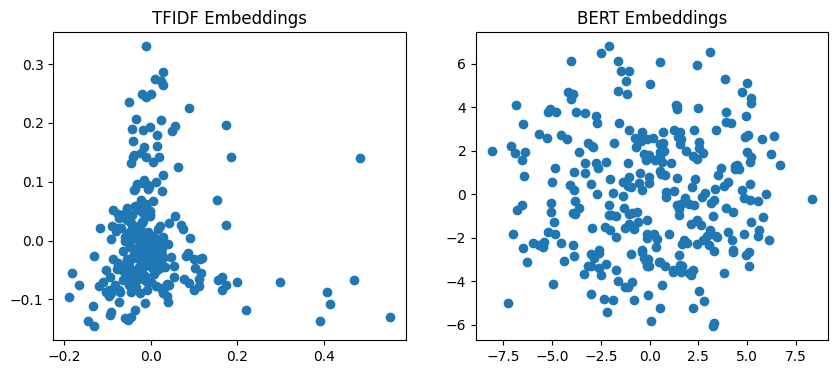

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax[0].set_title("TFIDF Embeddings")
ax[0].scatter(embs2[:, 0], embs2[:, 1], alpha=1);
ax[1].set_title("BERT Embeddings")
ax[1].scatter(embs1[:, 0], embs1[:, 1], alpha=1);